In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## StackOverflow Questions Count Time Series
### Consist of count of various questions of specific libraries for each month

In [714]:
df = pd.read_csv('MLTollsStackOverflow.csv', parse_dates=True, delimiter=',')

In [2]:
import plotly.express as px

fig = px.line(df, y=df.columns, x=df.month)
fig.show()

NameError: name 'df' is not defined

I will use PYTHON question counts as a target time series

In [716]:
df = df.python

In [717]:
fig = px.line(df)
fig.show()

### Check Seasonal Component

In [718]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

We can calculate the correlation for time series observations with observations with previous time steps

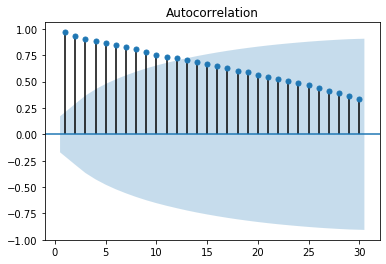

In [719]:
plot_acf(df, lags=30, zero=False)
plt.show()

A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

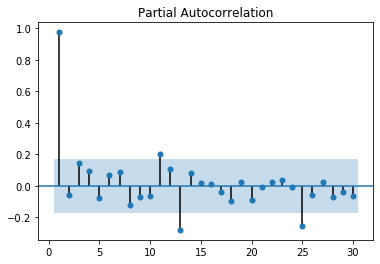

In [720]:
plot_pacf(df, lags=30, zero=False)
plt.show()

#### Based on the data from autocorrelation we can see no seasonal patterns 

Here we can also see that:
    1. ACF exponentially decrease
    2. PACF decrease but not completely to zero

### Taking this information into account, we can try using AR or ARMA model for the forecasting

### Test for stationarity

Null Hypothesis-Timeseries is non stationary Alternate Hypothesis-Timeseries is stationary

In [721]:
from statsmodels.tsa.stattools import adfuller

In [722]:
def test_stationary(timeseries):
    rolmean=timeseries.rolling(12).mean()
    rolstd=timeseries.rolling(12).std()
    orig=plt.plot(timeseries,color='blue',label='Original')
    mean=plt.plot(rolmean,color='red',label='mean')
    std=plt.plot(rolstd,color='black',label='rolling std')
    plt.legend(loc='best')
    plt.title('Rolling mean and standard deviation')
    plt.show(block=False)
    print("Result of Dickey Fuler Test:")
    dftest=adfuller(timeseries,autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistics','n_lags','p-value','nobs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Values(%s)'%key]=value
    print (dfoutput)

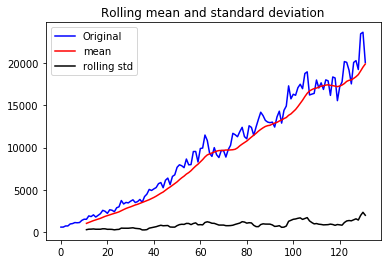

Result of Dickey Fuler Test:
Test Statistics           0.635425
n_lags                    0.988457
p-value                  13.000000
nobs                    118.000000
Critical Values(1%)      -3.487022
Critical Values(5%)      -2.886363
Critical Values(10%)     -2.580009
dtype: float64


In [723]:
test_stationary(df)

test statistic > critical values so we accept the null hypothesis i.e **Timeseries is non-stationary**

### Make differencing to achieve stationarity 

In [724]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

In [725]:
df = difference(df) 

#### Splitting the data into the train and test datasets 

In [726]:
df_train = df[0:100]
df_test = df[100:]

## Identification of the order and  examination of model estimations

In [727]:
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.arima_model import ARIMAResults, ARMAResults
from sklearn.metrics import mean_squared_error, r2_score

## p=4, q=7

In [728]:
armamodel = ARMA(np.asarray(df_train), order=(4,7))
armamodel_result = armamodel.fit()
print(armamodel_result.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  100
Model:                     ARMA(4, 7)   Log Likelihood                -770.241
Method:                       css-mle   S.D. of innovations            496.123
Date:                Wed, 16 Dec 2020   AIC                           1566.482
Time:                        02:14:22   BIC                           1600.349
Sample:                             0   HQIC                          1580.189
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        155.1117      5.867     26.440      0.000     143.613     166.610
ar.L1.y       -0.2220      0.121     -1.835      0.067      -0.459       0.015
ar.L2.y       -0.4917      0.136     -3.619      0.0

### Make a prediction on the test data

  Method      RMSE       R^2
0   ARMA  1559.171  0.080715


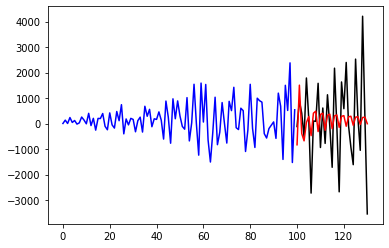

In [729]:
res = ARMAResults.predict(start=len(df_train), 
                          end=len(df_train)+len(df_test)-1, 
                          dynamic=False, 
                          self=armamodel_result)
rmse = round(np.sqrt(mean_squared_error(df_test, res)), 3)
r_2 = r2_score(df_test, res)

tempResultsDf = pd.DataFrame({'Method':['ARMA'], 'RMSE': [rmse], 'R^2': [r_2] })
print(tempResultsDf)
plt.plot(df_train, color = 'blue')
plt.plot(range(100,131), df_test, color = 'black')
plt.plot(range(100,131), res, color='red')
plt.show()

## p=2, q=3

In [730]:
armamodel = ARMA(np.asarray(df_train), order=(2,3))
armamodel_result = armamodel.fit()
print(armamodel_result.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  100
Model:                     ARMA(2, 3)   Log Likelihood                -777.135
Method:                       css-mle   S.D. of innovations            556.319
Date:                Wed, 16 Dec 2020   AIC                           1568.270
Time:                        02:14:23   BIC                           1586.507
Sample:                             0   HQIC                          1575.651
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        160.4815     40.072      4.005      0.000      81.941     239.022
ar.L1.y        0.0167      0.021      0.778      0.437      -0.025       0.059
ar.L2.y       -0.9839      0.017    -57.191      0.0

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



  Method      RMSE       R^2
0   ARMA  1466.708  0.186514


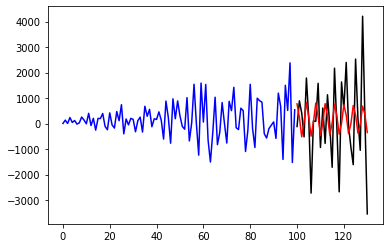

In [731]:
res = ARMAResults.predict(start=len(df_train), 
                          end=len(df_train)+len(df_test)-1, 
                          dynamic=False, 
                          self=armamodel_result)
rmse = round(np.sqrt(mean_squared_error(df_test, res)), 3)
r_2 = r2_score(df_test, res)

tempResultsDf = pd.DataFrame({'Method':['ARMA'], 'RMSE': [rmse], 'R^2': [r_2] })
print(tempResultsDf)
plt.plot(df_train, color = 'blue')
plt.plot(range(100,131), df_test, color = 'black')
plt.plot(range(100,131), res, color='red')
plt.show()

## p=3, q=5

In [732]:
armamodel = ARMA(np.asarray(df_train), order=(3,5))
armamodel_result = armamodel.fit()
print(armamodel_result.summary())

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning:

overflow encountered in exp

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning:

invalid value encountered in true_divide

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning:

overflow encountered in exp

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning:

invalid value encountered in true_divide

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  100
Model:                     ARMA(3, 5)   Log Likelihood                -787.309
Method:                       css-mle   S.D. of innovations                nan
Date:                Wed, 16 Dec 2020   AIC                           1594.618
Time:                        02:14:24   BIC                           1620.669
Sample:                             0   HQIC                          1605.161
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        161.0534        nan        nan        nan         nan         nan
ar.L1.y       -0.3967        nan        nan        nan         nan         nan
ar.L2.y       -0.9976   8.41e-07  -1.19e+06      0.0

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:1490: RuntimeWarning:

invalid value encountered in sqrt



  Method      RMSE       R^2
0   ARMA  1425.324  0.231773


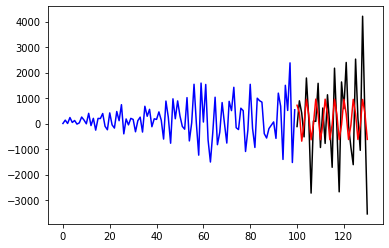

In [733]:
res = ARMAResults.predict(start=len(df_train), 
                          end=len(df_train)+len(df_test)-1, 
                          dynamic=False, 
                          self=armamodel_result)
rmse = round(np.sqrt(mean_squared_error(df_test, res)), 3)
r_2 = r2_score(df_test, res)

tempResultsDf = pd.DataFrame({'Method':['ARMA'], 'RMSE': [rmse], 'R^2': [r_2] })
print(tempResultsDf)
plt.plot(df_train, color = 'blue')
plt.plot(range(100,131), df_test, color = 'black')
plt.plot(range(100,131), res, color='red')
plt.show()

#### model diagnostics

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



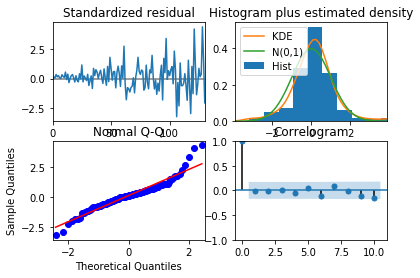

In [735]:
model3 = SARIMAX(df, order=(3,0,5))
results3 = model3.fit()

results3.plot_diagnostics()
plt.show()

#### Plot forecasts on train set

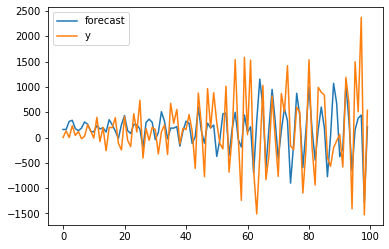

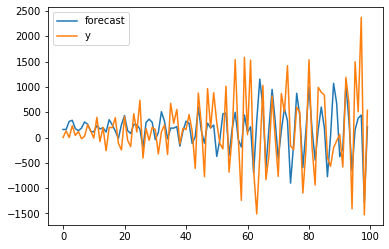

In [736]:
armamodel_result.plot_predict()

### The model with p=3 q=5 suits best the test set based on RMSE and R^2 metrics. 
### But The model with p=2 q=3 has lowest AIC or BIC value which indicates a better fit.